# HW6: Imitation Learning

> - Full Name: **Amir Kooshan Fattah Hesari**
> - Student ID: **401102191**
<!-- 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-5-Questions/blob/main/RL_HW11_Dyna.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Homework-11-Questions/main/RL_HW5_Dyna.ipynb) -->

## Overview
This assignment investigates the strengths and limitations of both reinforcement learning (PPO, A2C) and imitation learning (DAgger, GAIL) by applying them to control tasks. Students train and evaluate agents using expert demonstrations and environment feedback, gaining hands-on experience in designing and comparing learning algorithms across paradigms.


### **Exercise 1: Training PPO, A2C, and DAgger on CartPole-v1** (60 Points)

This exercise focuses on comparing reinforcement learning (PPO, A2C) and imitation learning (DAgger) techniques on the CartPole-v1 environment. An expert policy is first trained using PPO, then used to guide a DAgger agent. Separately, an A2C agent is trained directly via interaction with the environment. Performance metrics are collected to assess how each approach learns and generalizes.

---

### **Exercise 2: Training a GAIL Model Using an Expert Policy** (100 Points)

In this task, a GAIL (Generative Adversarial Imitation Learning) agent is trained to imitate a pre-trained expert policy in several environments (e.g., CartPole-v1, Pendulum-v0, BipedalWalker-v3). The training process involves configuring the environment, initializing models, and iteratively training the agent to match the expert’s behavior using adversarial learning.


In [3]:
import gymnasium as gym
from stable_baselines3 import PPO, DQN
from imitation.util.util import make_vec_env
from imitation.algorithms.dagger import SimpleDAggerTrainer
from imitation.algorithms import bc
from imitation.policies.serialize import load_policy
import os
import json
import pickle
import argparse
import torch
import tempfile
import numpy as np
from stable_baselines3 import PPO,DQN,A2C
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

# Training PPO, A2C, and DAgger on the CartPole-v1 Environment

In this section, we explore and compare multiple reinforcement learning and imitation learning approaches within the classic **CartPole-v1** environment. The algorithms used include:

- **Proximal Policy Optimization (PPO)** – a stable, on-policy RL algorithm.
- **Advantage Actor-Critic (A2C)** – another on-policy RL algorithm known for simplicity and efficiency.
- **DAgger (Dataset Aggregation)** – an imitation learning algorithm that iteratively refines a policy using expert guidance.

---

## Main Objectives

1. **Train an expert policy using PPO**.
2. **Use the PPO expert to train a new agent via DAgger**.
3. **Train a separate agent using A2C directly**.
4. **Compare performance between PPO, DAgger, and A2C**.

This setup allows us to analyze the strengths of:
- **Reinforcement learning** (PPO and A2C) that learns from environment feedback.
- **Imitation learning** (DAgger) that learns from an expert’s demonstrations and corrections.

---

### 1. PPO Expert Training (15 Points)
- A PPO agent is trained in the CartPole-v1 environment using `stable-baselines3`.
- The model is saved and later reloaded as an expert policy for imitation learning.
- Training is done in intervals and evaluated periodically to track average rewards.

In [4]:
# Create the CartPole-v1 environment
env = gym.make("CartPole-v1" , render_mode = "rgb_array")

model = PPO("MlpPolicy", env, verbose=1)
regular_rewards = []

# Training loop
total_timesteps = 10000
eval_freq = 1000 

for timestep in range(0, total_timesteps, eval_freq):
    model.learn(total_timesteps=eval_freq) 

    # TODO: Evaluate the model and record the reward
    reward, _ = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)
    regular_rewards.append(reward)

    print(f"Regular Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

model.save("CartPole_v1_PPO_model.zip")
env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.2     |
|    ep_rew_mean     | 23.2     |
| time/              |          |
|    fps             | 1076     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Regular Training - Step 1000: Mean Reward = 500.0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 25       |
| time/              |          |
|    fps             | 1205     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
Regular Training - Step 2000: Mean Reward = 411.4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 45.2     |
|    ep_rew_mean     | 45.2     |
| time/              |          |
|    fps             | 1213     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
Regular Training - Step 3000: Mean Reward = 390.0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 71.5     |
|    ep_rew_mean     | 71.5     |
| time/              |          |


### 2. DAgger Training with the PPO Expert (25 Points)
- A `BehaviorCloning` trainer is used to initialize the DAgger process.
- A `SimpleDAggerTrainer` collects data from both the expert and the learner during training.
- The model is updated incrementally and evaluated periodically.
- Performance rewards are stored to track learning progress.

In [6]:
# Load the PPO model manually using Stable-Baselines3's load method
rng = np.random.default_rng(0)
env = make_vec_env(
        "CartPole-v1",
        rng=rng,
    )
expert = PPO.load("CartPole_v1_PPO_model.zip")
# Initialize the Behavior Cloning (BC) trainer
bc_trainer = bc.BC(
    observation_space = env.observation_space,
    action_space = env.action_space,
    rng = rng,
)
# Record rewards during DAgger training
dagger_rewards = []

# Train using DAgger
with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
    dagger_trainer = SimpleDAggerTrainer(
        venv = env,
        scratch_dir =tmpdir,
        expert_policy =expert,
        bc_trainer = bc_trainer,
        rng = rng,
    )
    # Training loop for DAgger
    total_dagger_timesteps = 8000
    eval_freq = 1000
    for timestep in range(0, total_dagger_timesteps, eval_freq):
        dagger_trainer.train(eval_freq)

        # TODO: Evaluate the model and record the reward
        reward, _ = evaluate_policy(dagger_trainer.policy,env,10)
        dagger_rewards.append(reward)
        print(f"DAgger Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

model.save("CartPole_v1_DAgger_model.zip")
env.close()

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.692     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 32        |
|    return_mean    | 17.9      |
|    return_min     | 10        |
|    return_std     | 8.19      |
---------------------------------


112batch [00:00, 194.91batch/s]
239batch [00:01, 204.96batch/s]
370batch [00:01, 210.26batch/s]
498batch [00:02, 205.02batch/s]
500batch [00:02, 200.10batch/s]


DAgger Training - Step 1000: Mean Reward = 261.7


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000329 |
|    entropy        | 0.329     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 95        |
|    loss           | 0.317     |
|    neglogp        | 0.317     |
|    prob_true_act  | 0.779     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 385       |
|    return_mean    | 229       |
|    return_min     | 144       |
|    return_std     | 82.8      |
---------------------------------


245batch [00:01, 147.92batch/s]
485batch [00:03, 180.25batch/s]
Epoch 1 of 4                   

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000234 |
|    entropy        | 0.234     |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 126       |
|    loss           | 0.197     |
|    neglogp        | 0.198     |
|    prob_true_act  | 0.852     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 491       |
|    return_min     | 453       |
|    return_std     | 17        |
---------------------------------


748batch [00:05, 191.36batch/s]
992batch [00:07, 196.90batch/s]
1000batch [00:07, 140.46batch/s][A


DAgger Training - Step 2000: Mean Reward = 498.2


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000183 |
|    entropy        | 0.183     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 163       |
|    loss           | 0.143     |
|    neglogp        | 0.144     |
|    prob_true_act  | 0.889     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 497       |
|    return_min     | 472       |
|    return_std     | 8.8       |
---------------------------------


363batch [00:02, 192.04batch/s]
484batch [00:03, 195.38batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -0.0002  |
|    entropy        | 0.2      |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 192      |
|    loss           | 0.13     |
|    neglogp        | 0.131    |
|    prob_true_act  | 0.898    |
|    samples_so_far | 16032    |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 500      |
|    return_min     | 500      |
|    return_std     | 0        |
--------------------------------


742batch [00:05, 176.96batch/s]
987batch [00:06, 195.64batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -0.000166 |
|    entropy        | 0.166     |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 212       |
|    loss           | 0.113     |
|    neglogp        | 0.113     |
|    prob_true_act  | 0.914     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 496       |
|    return_min     | 460       |
|    return_std     | 12.6      |
---------------------------------


1109batch [00:07, 138.07batch/s]
1495batch [00:09, 193.39batch/s]
1500batch [00:10, 149.86batch/s]


DAgger Training - Step 3000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000141 |
|    entropy        | 0.141     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 232       |
|    loss           | 0.0717    |
|    neglogp        | 0.0718    |
|    prob_true_act  | 0.94      |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


490batch [00:03, 202.50batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000162 |
|    entropy        | 0.162     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 250       |
|    loss           | 0.0898    |
|    neglogp        | 0.09      |
|    prob_true_act  | 0.925     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


511batch [00:03, 85.82batch/s] 
988batch [00:06, 201.44batch/s][A

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -0.00012 |
|    entropy        | 0.12     |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 267      |
|    loss           | 0.0779   |
|    neglogp        | 0.0781   |
|    prob_true_act  | 0.938    |
|    samples_so_far | 32032    |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 500      |
|    return_min     | 500      |
|    return_std     | 0        |
--------------------------------


1009batch [00:06, 85.95batch/s]
1487batch [00:09, 195.36batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -0.000154 |
|    entropy        | 0.154     |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 282       |
|    loss           | 0.0703    |
|    neglogp        | 0.0705    |
|    prob_true_act  | 0.939     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1528batch [00:09, 102.63batch/s]
1985batch [00:12, 172.21batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -7.46e-05 |
|    entropy        | 0.0746    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 296       |
|    loss           | 0.202     |
|    neglogp        | 0.202     |
|    prob_true_act  | 0.913     |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 498       |
|    return_min     | 484       |
|    return_std     | 5.03      |
---------------------------------


2043batch [00:13, 78.97batch/s] 
2056batch [00:13, 151.37batch/s][A


DAgger Training - Step 4000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000188 |
|    entropy        | 0.188     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 298       |
|    loss           | 0.116     |
|    neglogp        | 0.116     |
|    prob_true_act  | 0.907     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


486batch [00:02, 197.94batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -0.00013 |
|    entropy        | 0.13     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 312      |
|    loss           | 0.0767   |
|    neglogp        | 0.0768   |
|    prob_true_act  | 0.941    |
|    samples_so_far | 16032    |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 500      |
|    return_min     | 500      |
|    return_std     | 0        |
--------------------------------


625batch [00:04, 167.35batch/s]
991batch [00:06, 188.01batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -0.000143 |
|    entropy        | 0.143     |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 323       |
|    loss           | 0.0851    |
|    neglogp        | 0.0852    |
|    prob_true_act  | 0.931     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1271batch [00:08, 189.74batch/s]
1492batch [00:09, 197.34batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -0.000127 |
|    entropy        | 0.127     |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 337       |
|    loss           | 0.097     |
|    neglogp        | 0.0972    |
|    prob_true_act  | 0.927     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1910batch [00:11, 187.72batch/s]
1990batch [00:12, 193.36batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -5.79e-05 |
|    entropy        | 0.0579    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 349       |
|    loss           | 0.0305    |
|    neglogp        | 0.0305    |
|    prob_true_act  | 0.974     |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2494batch [00:15, 197.64batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -9.76e-05 |
|    entropy        | 0.0976    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 359       |
|    loss           | 0.0422    |
|    neglogp        | 0.0423    |
|    prob_true_act  | 0.963     |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2553batch [00:16, 116.09batch/s]
2556batch [00:16, 158.13batch/s]


DAgger Training - Step 5000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -6.25e-05 |
|    entropy        | 0.0625    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 361       |
|    loss           | 0.0274    |
|    neglogp        | 0.0275    |
|    prob_true_act  | 0.976     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


500batch [00:03, 187.11batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -1.9e-05 |
|    entropy        | 0.019    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 371      |
|    loss           | 0.00462  |
|    neglogp        | 0.00464  |
|    prob_true_act  | 0.995    |
|    samples_so_far | 16032    |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 500      |
|    return_min     | 500      |
|    return_std     | 0        |
--------------------------------


755batch [00:04, 174.93batch/s]
995batch [00:06, 174.54batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -6.24e-05 |
|    entropy        | 0.0624    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 380       |
|    loss           | 0.0409    |
|    neglogp        | 0.041     |
|    prob_true_act  | 0.969     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1484batch [00:09, 185.31batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -0.000113 |
|    entropy        | 0.113     |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 387       |
|    loss           | 0.0731    |
|    neglogp        | 0.0732    |
|    prob_true_act  | 0.942     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1519batch [00:10, 81.61batch/s] 
1984batch [00:13, 191.11batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -9.94e-05 |
|    entropy        | 0.0994    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 399       |
|    loss           | 0.108     |
|    neglogp        | 0.108     |
|    prob_true_act  | 0.93      |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 498       |
|    return_min     | 481       |
|    return_std     | 5.97      |
---------------------------------


2277batch [00:15, 181.95batch/s]
2493batch [00:16, 195.60batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -4.61e-05 |
|    entropy        | 0.0461    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 403       |
|    loss           | 0.0252    |
|    neglogp        | 0.0252    |
|    prob_true_act  | 0.979     |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2982batch [00:19, 188.88batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3000      |
|    ent_loss       | -7.78e-05 |
|    entropy        | 0.0778    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 413       |
|    loss           | 0.0703    |
|    neglogp        | 0.0704    |
|    prob_true_act  | 0.952     |
|    samples_so_far | 96032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


3039batch [00:20, 112.99batch/s]
3056batch [00:20, 147.53batch/s]


DAgger Training - Step 6000: Mean Reward = 497.5


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -4.99e-05 |
|    entropy        | 0.0499    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 414       |
|    loss           | 0.0394    |
|    neglogp        | 0.0395    |
|    prob_true_act  | 0.971     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 498       |
|    return_min     | 483       |
|    return_std     | 5.34      |
---------------------------------


488batch [00:03, 204.28batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -4.48e-05 |
|    entropy        | 0.0448    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 421       |
|    loss           | 0.0178    |
|    neglogp        | 0.0179    |
|    prob_true_act  | 0.984     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 498       |
|    return_std     | 0.629     |
---------------------------------


880batch [00:06, 201.71batch/s]
987batch [00:06, 207.24batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -2.82e-05 |
|    entropy        | 0.0282    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 429       |
|    loss           | 0.00939   |
|    neglogp        | 0.00942   |
|    prob_true_act  | 0.991     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 499       |
|    return_min     | 487       |
|    return_std     | 4.09      |
---------------------------------


1491batch [00:10, 209.22batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -5.04e-05 |
|    entropy        | 0.0504    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 436       |
|    loss           | 0.0362    |
|    neglogp        | 0.0363    |
|    prob_true_act  | 0.972     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1763batch [00:12, 202.51batch/s]
1999batch [00:13, 209.06batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -6.36e-05 |
|    entropy        | 0.0636    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 444       |
|    loss           | 0.0396    |
|    neglogp        | 0.0397    |
|    prob_true_act  | 0.968     |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2486batch [00:16, 191.00batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -7.33e-05 |
|    entropy        | 0.0733    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 449       |
|    loss           | 0.0502    |
|    neglogp        | 0.0503    |
|    prob_true_act  | 0.961     |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 481       |
|    return_min     | 346       |
|    return_std     | 46.2      |
---------------------------------


2667batch [00:17, 172.96batch/s]
2985batch [00:19, 151.72batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3000      |
|    ent_loss       | -9.31e-05 |
|    entropy        | 0.0931    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 456       |
|    loss           | 0.11      |
|    neglogp        | 0.11      |
|    prob_true_act  | 0.93      |
|    samples_so_far | 96032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


3489batch [00:22, 194.28batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3500      |
|    ent_loss       | -8.64e-05 |
|    entropy        | 0.0864    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 463       |
|    loss           | 0.0535    |
|    neglogp        | 0.0536    |
|    prob_true_act  | 0.958     |
|    samples_so_far | 112032    |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


3549batch [00:23, 115.33batch/s]
3556batch [00:23, 149.69batch/s]


DAgger Training - Step 7000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -5.99e-06 |
|    entropy        | 0.00599   |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 464       |
|    loss           | 0.000982  |
|    neglogp        | 0.000988  |
|    prob_true_act  | 0.999     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 498       |
|    return_min     | 482       |
|    return_std     | 5.66      |
---------------------------------


500batch [00:03, 202.47batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -4.55e-05 |
|    entropy        | 0.0455    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 470       |
|    loss           | 0.0321    |
|    neglogp        | 0.0321    |
|    prob_true_act  | 0.976     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


993batch [00:06, 196.83batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -2.7e-05 |
|    entropy        | 0.027    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 475      |
|    loss           | 0.0187   |
|    neglogp        | 0.0188   |
|    prob_true_act  | 0.985    |
|    samples_so_far | 32032    |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 499      |
|    return_min     | 487      |
|    return_std     | 4.09     |
--------------------------------


1013batch [00:07, 54.47batch/s]
1487batch [00:09, 195.01batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -6.76e-05 |
|    entropy        | 0.0676    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 480       |
|    loss           | 0.0509    |
|    neglogp        | 0.051     |
|    prob_true_act  | 0.961     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1984batch [00:12, 201.00batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -7.14e-05 |
|    entropy        | 0.0714    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 483       |
|    loss           | 0.234     |
|    neglogp        | 0.234     |
|    prob_true_act  | 0.907     |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2045batch [00:13, 120.04batch/s]
2482batch [00:15, 184.84batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -5.27e-05 |
|    entropy        | 0.0527    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 486       |
|    loss           | 0.0303    |
|    neglogp        | 0.0304    |
|    prob_true_act  | 0.976     |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


2986batch [00:18, 191.77batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3000      |
|    ent_loss       | -7.13e-05 |
|    entropy        | 0.0713    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 491       |
|    loss           | 0.032     |
|    neglogp        | 0.0321    |
|    prob_true_act  | 0.972     |
|    samples_so_far | 96032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


3085batch [00:19, 142.25batch/s]
3484batch [00:22, 190.18batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3500      |
|    ent_loss       | -6.88e-05 |
|    entropy        | 0.0688    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 498       |
|    loss           | 0.0454    |
|    neglogp        | 0.0455    |
|    prob_true_act  | 0.965     |
|    samples_so_far | 112032    |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 498       |
|    return_min     | 482       |
|    return_std     | 5.66      |
---------------------------------


3992batch [00:25, 165.43batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 4000      |
|    ent_loss       | -0.000115 |
|    entropy        | 0.115     |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 501       |
|    loss           | 0.0797    |
|    neglogp        | 0.0798    |
|    prob_true_act  | 0.939     |
|    samples_so_far | 128032    |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


4108batch [00:26, 144.02batch/s]
4116batch [00:26, 152.84batch/s]


DAgger Training - Step 8000: Mean Reward = 500.0


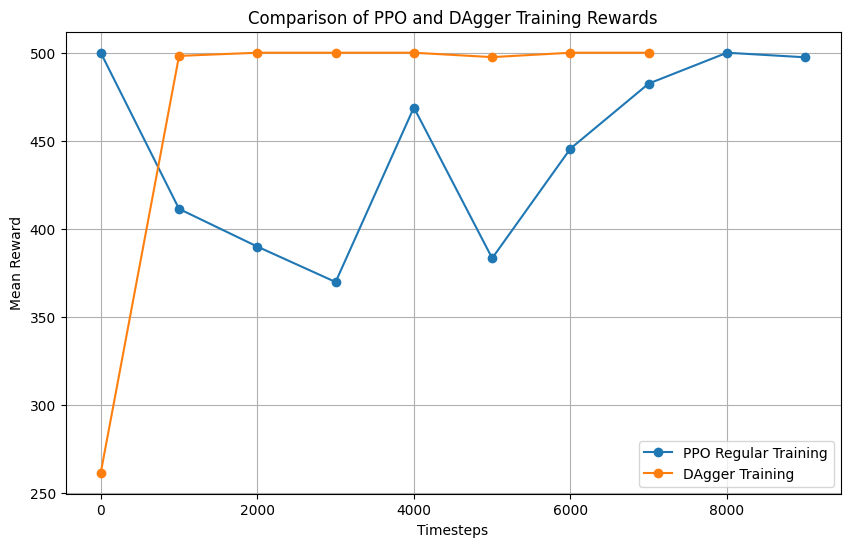

In [7]:
# Plot the rewards for Regular PPO Training and DAgger Training
plt.figure(figsize=(10, 6))
plt.plot(range(0, 10000, 1000), regular_rewards, label="PPO Regular Training", marker="o")
plt.plot(range(0, 8000, 1000), dagger_rewards, label="DAgger Training", marker="o")
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("Comparison of PPO and DAgger Training Rewards")
plt.legend()
plt.grid(True)
plt.savefig("ppo_vs_dagger.pdf")
plt.show()


### 3. A2C Agent Training (20 Points)
After DAgger training, a third agent is trained using the **Advantage Actor-Critic (A2C)** algorithm.

In [16]:
# Create the CartPole-v1 environment
env = gym.make('CartPole-v1')

# Initialize the A2C model
model = A2C('MlpPolicy', env, verbose=1)

# Record rewards during training
regular_rewards = []

# Training loop
total_timesteps = 10000
eval_freq = 1000 
for timestep in range(0, total_timesteps, eval_freq):
    model.learn(total_timesteps=eval_freq) 
    # TODO: Evaluate the model and record the reward
    reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
    regular_rewards.append(reward)
    print(f"Regular Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

# Save the model after training
model.save("CartPole_v1_A2C_model.zip")
env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.3     |
|    ep_rew_mean        | 18.3     |
| time/                 |          |
|    fps                | 531      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 0.0262   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -2.89    |
|    value_loss         | 19.6     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 19.2     |
|    ep_rew_mean        | 19.2     |
| time/                 |          |
|    fps                | 536      |
|    iterations         | 200      |
|    time_elapsed 

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 21.5     |
|    ep_rew_mean        | 21.5     |
| time/                 |          |
|    fps                | 566      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | -0.00613 |
|    learning_rate      | 0.0007   |
|    n_updates          | 299      |
|    policy_loss        | 1.67     |
|    value_loss         | 7.06     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 21.1     |
|    ep_rew_mean        | 21.1     |
| time/                 |          |
|    fps                | 558      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|

In [17]:
# Load the A2C model manually using Stable-Baselines3's load method
expert = A2C.load("CartPole_v1_A2C_model.zip")
rng = np.random.default_rng(0)
env = make_vec_env(
        "CartPole-v1",
        rng=rng,
    )
# Initialize the Behavior Cloning (BC) trainer
bc_trainer = bc.BC(
    observation_space = env.observation_space,
    action_space = env.action_space,
    rng = rng,
)
# Record rewards during DAgger training
dagger_rewards = []

# Train using DAgger
with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
    dagger_trainer = SimpleDAggerTrainer(
        venv = env,
        scratch_dir =tmpdir,
        expert_policy =expert,
        bc_trainer = bc_trainer,
        rng = rng,
    )
    # Training loop for DAgger
    total_dagger_timesteps = 8000
    eval_freq = 1000 
    for timestep in range(0, total_dagger_timesteps, eval_freq):
        dagger_trainer.train(eval_freq)  # Train the agent for `eval_freq` timesteps

        # TODO: Evaluate the model and record the reward
        reward, _ = evaluate_policy(dagger_trainer.policy, env, n_eval_episodes=10, deterministic=True)
        dagger_rewards.append(reward)
        print(f"DAgger Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

# Close the environment after DAgger training
env.close()

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.693     |
|    neglogp        | 0.694     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 49        |
|    return_mean    | 24.2      |
|    return_min     | 10        |
|    return_std     | 11.3      |
---------------------------------


132batch [00:00, 191.57batch/s]
253batch [00:01, 190.40batch/s]
391batch [00:02, 190.68batch/s]
490batch [00:02, 188.43batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -0.00027 |
|    entropy        | 0.27     |
|    epoch          | 3        |
|    l2_loss        | 0        |
|    l2_norm        | 97.7     |
|    loss           | 0.211    |
|    neglogp        | 0.211    |
|    prob_true_act  | 0.844    |
|    samples_so_far | 16032    |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 401      |
|    return_min     | 321      |
|    return_std     | 54.9     |
--------------------------------


529batch [00:03, 70.90batch/s] 
536batch [00:03, 145.17batch/s][A


DAgger Training - Step 1000: Mean Reward = 458.1


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000266 |
|    entropy        | 0.266     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 99.3      |
|    loss           | 0.231     |
|    neglogp        | 0.232     |
|    prob_true_act  | 0.832     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 433       |
|    return_min     | 339       |
|    return_std     | 59.9      |
---------------------------------


260batch [00:02, 193.26batch/s]
483batch [00:03, 195.85batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000181 |
|    entropy        | 0.181     |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 121       |
|    loss           | 0.172     |
|    neglogp        | 0.172     |
|    prob_true_act  | 0.881     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 498       |
|    return_min     | 486       |
|    return_std     | 4.4       |
---------------------------------


541batch [00:04, 81.50batch/s] 
818batch [00:05, 190.52batch/s][A
998batch [00:06, 190.60batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -0.000135 |
|    entropy        | 0.135     |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 139       |
|    loss           | 0.115     |
|    neglogp        | 0.115     |
|    prob_true_act  | 0.916     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 425       |
|    return_min     | 283       |
|    return_std     | 72.8      |
---------------------------------


1096batch [00:08, 118.63batch/s]
1112batch [00:08, 132.74batch/s]


DAgger Training - Step 2000: Mean Reward = 387.8


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000167 |
|    entropy        | 0.167     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 143       |
|    loss           | 0.111     |
|    neglogp        | 0.111     |
|    prob_true_act  | 0.914     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 379       |
|    return_min     | 243       |
|    return_std     | 74.8      |
---------------------------------


392batch [00:02, 203.32batch/s]
496batch [00:03, 200.77batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -6.2e-05 |
|    entropy        | 0.062    |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 159      |
|    loss           | 0.0494   |
|    neglogp        | 0.0495   |
|    prob_true_act  | 0.965    |
|    samples_so_far | 16032    |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 421      |
|    return_min     | 289      |
|    return_std     | 80.1     |
--------------------------------


820batch [00:05, 188.78batch/s]
999batch [00:06, 192.23batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -7.31e-05 |
|    entropy        | 0.0731    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 173       |
|    loss           | 0.0577    |
|    neglogp        | 0.0578    |
|    prob_true_act  | 0.957     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 437       |
|    return_min     | 319       |
|    return_std     | 70.7      |
---------------------------------


1218batch [00:08, 182.74batch/s]
1492batch [00:10, 187.74batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -8.22e-05 |
|    entropy        | 0.0822    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 185       |
|    loss           | 0.0387    |
|    neglogp        | 0.0388    |
|    prob_true_act  | 0.966     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 430       |
|    return_min     | 228       |
|    return_std     | 90.4      |
---------------------------------


1629batch [00:11, 148.80batch/s]
1640batch [00:11, 139.59batch/s]


DAgger Training - Step 3000: Mean Reward = 420.4


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -8.81e-05 |
|    entropy        | 0.0881    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 188       |
|    loss           | 0.0579    |
|    neglogp        | 0.058     |
|    prob_true_act  | 0.954     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 398       |
|    return_min     | 280       |
|    return_std     | 78.7      |
---------------------------------


498batch [00:04, 176.84batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -8.23e-05 |
|    entropy        | 0.0823    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 200       |
|    loss           | 0.0464    |
|    neglogp        | 0.0465    |
|    prob_true_act  | 0.962     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 376       |
|    return_min     | 264       |
|    return_std     | 80.1      |
---------------------------------


555batch [00:05, 80.55batch/s] 
993batch [00:07, 198.01batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -4.96e-05 |
|    entropy        | 0.0496    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 209       |
|    loss           | 0.0234    |
|    neglogp        | 0.0234    |
|    prob_true_act  | 0.98      |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 450       |
|    return_min     | 323       |
|    return_std     | 62        |
---------------------------------


1108batch [00:09, 128.72batch/s]
1491batch [00:11, 180.32batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -4.94e-05 |
|    entropy        | 0.0494    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 216       |
|    loss           | 0.0864    |
|    neglogp        | 0.0865    |
|    prob_true_act  | 0.96      |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 469       |
|    return_min     | 291       |
|    return_std     | 67        |
---------------------------------


1660batch [00:13, 160.98batch/s]
1990batch [00:15, 161.84batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 2000     |
|    ent_loss       | -2.9e-05 |
|    entropy        | 0.029    |
|    epoch          | 3        |
|    l2_loss        | 0        |
|    l2_norm        | 223      |
|    loss           | 0.0103   |
|    neglogp        | 0.0103   |
|    prob_true_act  | 0.99     |
|    samples_so_far | 64032    |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 400      |
|    return_min     | 298      |
|    return_std     | 62.8     |
--------------------------------


2212batch [00:17, 173.80batch/s]
2220batch [00:17, 126.83batch/s]


DAgger Training - Step 4000: Mean Reward = 419.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -4.83e-05 |
|    entropy        | 0.0483    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 227       |
|    loss           | 0.0224    |
|    neglogp        | 0.0225    |
|    prob_true_act  | 0.98      |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 404       |
|    return_min     | 286       |
|    return_std     | 77.5      |
---------------------------------


493batch [00:03, 186.59batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -7.42e-05 |
|    entropy        | 0.0742    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 234       |
|    loss           | 0.0312    |
|    neglogp        | 0.0313    |
|    prob_true_act  | 0.972     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 457       |
|    return_min     | 297       |
|    return_std     | 63.9      |
---------------------------------


669batch [00:05, 161.57batch/s]
987batch [00:07, 190.60batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -5.07e-05 |
|    entropy        | 0.0507    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 240       |
|    loss           | 0.022     |
|    neglogp        | 0.022     |
|    prob_true_act  | 0.981     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 381       |
|    return_min     | 275       |
|    return_std     | 83.1      |
---------------------------------


1344batch [00:09, 187.97batch/s]
1499batch [00:10, 190.96batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -6.66e-05 |
|    entropy        | 0.0666    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 245       |
|    loss           | 0.0395    |
|    neglogp        | 0.0395    |
|    prob_true_act  | 0.968     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 398       |
|    return_min     | 242       |
|    return_std     | 93.7      |
---------------------------------


1981batch [00:13, 190.86batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -4.92e-05 |
|    entropy        | 0.0492    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 252       |
|    loss           | 0.0863    |
|    neglogp        | 0.0864    |
|    prob_true_act  | 0.959     |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 398       |
|    return_min     | 259       |
|    return_std     | 93.7      |
---------------------------------


2021batch [00:14, 66.96batch/s] 
2495batch [00:17, 189.87batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -9.09e-05 |
|    entropy        | 0.0909    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 255       |
|    loss           | 0.0425    |
|    neglogp        | 0.0425    |
|    prob_true_act  | 0.963     |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 407       |
|    return_min     | 307       |
|    return_std     | 74.3      |
---------------------------------


2690batch [00:19, 169.48batch/s]
2708batch [00:19, 139.44batch/s]


DAgger Training - Step 5000: Mean Reward = 380.9


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -5.56e-05 |
|    entropy        | 0.0556    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 257       |
|    loss           | 0.0872    |
|    neglogp        | 0.0873    |
|    prob_true_act  | 0.955     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 470       |
|    return_min     | 297       |
|    return_std     | 62.4      |
---------------------------------


482batch [00:03, 184.86batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -2.18e-05 |
|    entropy        | 0.0218    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 264       |
|    loss           | 0.00617   |
|    neglogp        | 0.00619   |
|    prob_true_act  | 0.994     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 454       |
|    return_min     | 270       |
|    return_std     | 88.7      |
---------------------------------


850batch [00:06, 182.24batch/s]
982batch [00:07, 184.42batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -4.38e-05 |
|    entropy        | 0.0438    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 269       |
|    loss           | 0.016     |
|    neglogp        | 0.016     |
|    prob_true_act  | 0.985     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 421       |
|    return_min     | 281       |
|    return_std     | 75.9      |
---------------------------------


1499batch [00:11, 176.65batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -1.49e-05 |
|    entropy        | 0.0149    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 273       |
|    loss           | 0.00405   |
|    neglogp        | 0.00406   |
|    prob_true_act  | 0.996     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 454       |
|    return_min     | 357       |
|    return_std     | 58        |
---------------------------------


1684batch [00:13, 165.50batch/s]
1987batch [00:14, 178.40batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -8.59e-05 |
|    entropy        | 0.0859    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 275       |
|    loss           | 0.0562    |
|    neglogp        | 0.0563    |
|    prob_true_act  | 0.957     |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 406       |
|    return_min     | 266       |
|    return_std     | 87.9      |
---------------------------------


2492batch [00:18, 179.27batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -4.39e-05 |
|    entropy        | 0.0439    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 279       |
|    loss           | 0.0316    |
|    neglogp        | 0.0317    |
|    prob_true_act  | 0.976     |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 428       |
|    return_min     | 293       |
|    return_std     | 86.6      |
---------------------------------


2546batch [00:19, 78.56batch/s] 
2999batch [00:22, 171.90batch/s][A

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3000      |
|    ent_loss       | -1.29e-05 |
|    entropy        | 0.0129    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 282       |
|    loss           | 0.00358   |
|    neglogp        | 0.00359   |
|    prob_true_act  | 0.997     |
|    samples_so_far | 96032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 441       |
|    return_min     | 288       |
|    return_std     | 87.3      |
---------------------------------


3399batch [00:25, 155.71batch/s]
3404batch [00:25, 133.81batch/s]


DAgger Training - Step 6000: Mean Reward = 407.7


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -4.77e-05 |
|    entropy        | 0.0477    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 288       |
|    loss           | 0.0185    |
|    neglogp        | 0.0186    |
|    prob_true_act  | 0.983     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 420       |
|    return_min     | 270       |
|    return_std     | 93.6      |
---------------------------------


488batch [00:03, 179.84batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -2.88e-05 |
|    entropy        | 0.0288    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 291       |
|    loss           | 0.00867   |
|    neglogp        | 0.0087    |
|    prob_true_act  | 0.992     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 401       |
|    return_min     | 267       |
|    return_std     | 92.9      |
---------------------------------


972batch [00:07, 183.12batch/s]
991batch [00:07, 180.52batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -4.28e-05 |
|    entropy        | 0.0428    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 295       |
|    loss           | 0.0404    |
|    neglogp        | 0.0404    |
|    prob_true_act  | 0.97      |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 417       |
|    return_min     | 280       |
|    return_std     | 88.6      |
---------------------------------


1489batch [00:10, 174.57batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -4.77e-05 |
|    entropy        | 0.0477    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 296       |
|    loss           | 0.0239    |
|    neglogp        | 0.024     |
|    prob_true_act  | 0.979     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 392       |
|    return_min     | 230       |
|    return_std     | 110       |
---------------------------------


1956batch [00:14, 165.98batch/s]
1991batch [00:14, 166.80batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -5.23e-05 |
|    entropy        | 0.0523    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 302       |
|    loss           | 0.0279    |
|    neglogp        | 0.028     |
|    prob_true_act  | 0.976     |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 444       |
|    return_min     | 301       |
|    return_std     | 66.5      |
---------------------------------


2486batch [00:18, 180.42batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -5.56e-05 |
|    entropy        | 0.0556    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 306       |
|    loss           | 0.0525    |
|    neglogp        | 0.0525    |
|    prob_true_act  | 0.965     |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 446       |
|    return_min     | 290       |
|    return_std     | 72.6      |
---------------------------------


2933batch [00:21, 175.70batch/s]
2988batch [00:22, 176.34batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3000      |
|    ent_loss       | -1.55e-05 |
|    entropy        | 0.0155    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 309       |
|    loss           | 0.00493   |
|    neglogp        | 0.00494   |
|    prob_true_act  | 0.995     |
|    samples_so_far | 96032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 447       |
|    return_min     | 256       |
|    return_std     | 89.1      |
---------------------------------


3493batch [00:25, 179.67batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3500      |
|    ent_loss       | -5.15e-05 |
|    entropy        | 0.0515    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 311       |
|    loss           | 0.0295    |
|    neglogp        | 0.0295    |
|    prob_true_act  | 0.976     |
|    samples_so_far | 112032    |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 431       |
|    return_min     | 299       |
|    return_std     | 77.9      |
---------------------------------


3901batch [00:29, 173.10batch/s]
3912batch [00:29, 134.32batch/s]


DAgger Training - Step 7000: Mean Reward = 433.2


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -2.41e-05 |
|    entropy        | 0.0241    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 311       |
|    loss           | 0.0186    |
|    neglogp        | 0.0187    |
|    prob_true_act  | 0.986     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 426       |
|    return_min     | 279       |
|    return_std     | 78.9      |
---------------------------------


482batch [00:03, 180.34batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -5.43e-05 |
|    entropy        | 0.0543    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 316       |
|    loss           | 0.0464    |
|    neglogp        | 0.0464    |
|    prob_true_act  | 0.966     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 404       |
|    return_min     | 250       |
|    return_std     | 97        |
---------------------------------


998batch [00:07, 188.55batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -1.27e-05 |
|    entropy        | 0.0127    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 318       |
|    loss           | 0.00467   |
|    neglogp        | 0.00469   |
|    prob_true_act  | 0.996     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 462       |
|    return_min     | 285       |
|    return_std     | 76.5      |
---------------------------------


1095batch [00:08, 124.87batch/s]
1482batch [00:10, 183.05batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -5.24e-05 |
|    entropy        | 0.0524    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 320       |
|    loss           | 0.0287    |
|    neglogp        | 0.0287    |
|    prob_true_act  | 0.976     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 448       |
|    return_min     | 287       |
|    return_std     | 69.8      |
---------------------------------


1995batch [00:14, 182.69batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -2.55e-05 |
|    entropy        | 0.0255    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 323       |
|    loss           | 0.0177    |
|    neglogp        | 0.0177    |
|    prob_true_act  | 0.986     |
|    samples_so_far | 64032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 415       |
|    return_min     | 288       |
|    return_std     | 85.5      |
---------------------------------


2187batch [00:16, 168.70batch/s]
2498batch [00:18, 190.22batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -7.42e-05 |
|    entropy        | 0.0742    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 318       |
|    loss           | 0.0354    |
|    neglogp        | 0.0355    |
|    prob_true_act  | 0.97      |
|    samples_so_far | 80032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 451       |
|    return_min     | 286       |
|    return_std     | 71.9      |
---------------------------------


2995batch [00:21, 188.14batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3000      |
|    ent_loss       | -3.88e-05 |
|    entropy        | 0.0388    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 320       |
|    loss           | 0.0228    |
|    neglogp        | 0.0228    |
|    prob_true_act  | 0.982     |
|    samples_so_far | 96032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 427       |
|    return_min     | 265       |
|    return_std     | 88.6      |
---------------------------------


3283batch [00:23, 181.84batch/s]
3493batch [00:25, 186.64batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3500      |
|    ent_loss       | -6.74e-05 |
|    entropy        | 0.0674    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 323       |
|    loss           | 0.034     |
|    neglogp        | 0.0341    |
|    prob_true_act  | 0.971     |
|    samples_so_far | 112032    |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 461       |
|    return_min     | 252       |
|    return_std     | 73.9      |
---------------------------------


3982batch [00:28, 188.80batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 4000      |
|    ent_loss       | -7.23e-05 |
|    entropy        | 0.0723    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 325       |
|    loss           | 0.0955    |
|    neglogp        | 0.0955    |
|    prob_true_act  | 0.942     |
|    samples_so_far | 128032    |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 412       |
|    return_min     | 270       |
|    return_std     | 102       |
---------------------------------


4367batch [00:31, 183.42batch/s]
4380batch [00:31, 139.37batch/s]


DAgger Training - Step 8000: Mean Reward = 386.3


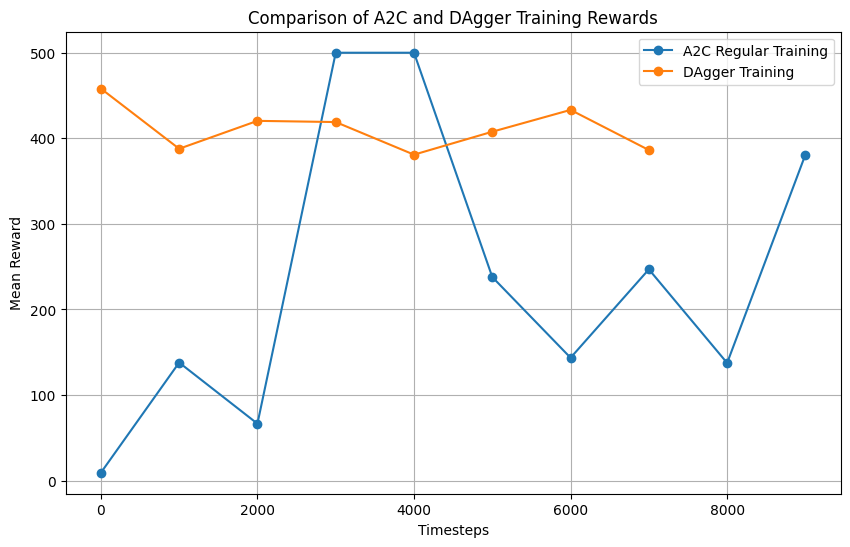

In [18]:
# Plot the rewards for Regular A2C Training and DAgger Training
plt.figure(figsize=(10, 6))
plt.plot(range(0, 10000, 1000), regular_rewards, label="A2C Regular Training", marker="o")
plt.plot(range(0, 8000, 1000), dagger_rewards, label="DAgger Training", marker="o")

plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("Comparison of A2C and DAgger Training Rewards")
plt.legend()

plt.grid(True)
plt.savefig("A2C_vs_Dagger.pdf")
plt.show()

# Training a GAIL Model Using an Expert Policy

In this section, we walk through the process of setting up and training a **Generative Adversarial Imitation Learning (GAIL)** model using a pre-trained expert in environments such as `CartPole-v1`, `Pendulum-v0`, and `BipedalWalker-v3`.

The full pipeline includes:
- Setting up directories and configurations,
- Loading and validating the environment,
- Initializing expert and GAIL models,
- Training GAIL using the expert’s behavior,
- Saving the final results and model weights.

## Summary

This pipeline implements a complete imitation learning workflow using GAIL. The process involves:
- Setting up a Gym-compatible environment,
- Loading a pre-trained expert model,
- Training a GAIL agent to mimic the expert,
- Storing the training results and model artifacts.

By following this structure, we can compare GAIL's performance to reinforcement learning approaches like PPO or A2C, and evaluate the efficiency of learning from demonstrations.

---


### **1. `setup_directories(env_name)`** (5 Points)

```python
This function handles directory setup and expert configuration:
- Creates a base checkpoint directory (`ckpts/`).
- Validates if the provided environment name is supported.
- Loads the expert model configuration from a JSON file.
- Creates a subdirectory for storing environment-specific checkpoints.

**Purpose:** Prepare the file system and load settings for the expert model.

In [1]:
import os
import json
import pickle
import argparse
import torch
import gym

In [2]:
import shutil
shutil.copytree("/kaggle/input/gailmodels" , "/kaggle/working/gail_model")
os.chdir("/kaggle/working/gail_model")

In [3]:
import sys
sys.path.append('/kaggle/working/gail_model')
from nets import *
from gail import *
from funcs import *

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
def setup_directories(env_name):
    ckpt_path = "ckpts"
    if not os.path.isdir(ckpt_path):
        os.mkdir(ckpt_path)
    print(ckpt_path)
    expert_ckpt_path = "/kaggle/input/gailmodels"   
    # TODO: Ensure that the expert model config file exists and can be loaded
    with open(os.path.join(expert_ckpt_path, "model_config.json")) as f:
        expert_config = json.load(f)

    ckpt_path = os.path.join(ckpt_path, env_name)
    if not os.path.isdir(ckpt_path):
        os.mkdir(ckpt_path)
    return expert_ckpt_path, expert_config, ckpt_path

### **2. `load_and_save_configs(expert_ckpt_path, ckpt_path, env_name)`** (10 Points)
- Loads a general configuration file (`config.json`) that contains training hyperparameters specific to the environment.
- Saves these configurations to the current checkpoint folder for logging and reproducibility.

**Purpose:** Fetch and store hyperparameters needed for training the GAIL model.

In [5]:
def load_and_save_configs(expert_ckpt_path, ckpt_path, env_name):
    # TODO: Ensure that the global config.json file exists and can be loaded
    with open("/kaggle/input/configuration/config.json") as f:
        config = json.load(f)[env_name]
    # TODO: Confirm that the config is being written correctly
    with open(os.path.join(ckpt_path, "model_config.json"), "w") as f:
        json.dump(config, f, indent=4)
    return config

### **3. `setup_environment(env_name)`** (10 Points)

- Initializes the chosen environment using OpenAI Gym.
- Extracts the dimensions of the state and action spaces.
- Checks whether the action space is discrete (e.g., CartPole) or continuous (e.g., Pendulum).

**Purpose:** Provide key environment information for model initialization.


In [6]:
def setup_environment(env_name):
    # TODO: Verify that the environment is being created and reset properly
    env = gym.make(env_name)
    env.reset()
    # TODO: Double-check the dimensions of state and action spaces for each environment
    state_dim = len(env.observation_space.high)
    discrete = True
    action_dim = env.action_space.n
    return env, state_dim, action_dim, discrete

### **4. `setup_device()`** (+5 Points for running on GPU)
- Checks if a GPU (`cuda`) is available.
- Falls back to CPU if GPU is not detected.

**Purpose:** Ensure the training runs on the optimal hardware available.


In [8]:
def setup_device():
    # TODO: Ensure device compatibility and fallback to CPU if no GPU available
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    return device

### **5. `initialize_expert(...)`** (15 Points)

- Initializes an `Expert` model using its architecture config and environment dimensions.
- Loads pre-trained policy weights (`policy.ckpt`) from the expert checkpoint.

**Purpose:** Prepare a high-performance expert model whose behavior GAIL will learn to imitate.

In [9]:
def initialize_expert(expert_ckpt_path, state_dim, action_dim, discrete, expert_config, device):
    # TODO: Confirm that the Expert class is loaded with the correct parameters
    # TODO: Ensure that the policy checkpoint for the expert is available
    expert = Expert(
        state_dim, action_dim, discrete, **expert_config
    ).to(device)
    expert.pi.load_state_dict(
        torch.load(
            os.path.join(expert_ckpt_path, "policy.ckpt"), map_location=device
        )
    )
    return expert

### **6. `initialize_gail_model(...)`** (15 Points)
- Initializes the `GAIL` model using environment specs and configuration parameters.
- The model includes a policy, value function, and discriminator.

**Purpose:** Set up the GAIL agent that learns by interacting with the environment and distinguishing between expert and learner behavior.


In [10]:
def initialize_gail_model(state_dim, action_dim, discrete, config, device):
    # TODO: Verify that the GAIL model is initialized correctly with the config
    model = GAIL(state_dim, action_dim, discrete, config).to(device)
    return model

### **7. `train_gail_model(model, env, expert)`** (20 Points)
- Runs the training loop for the GAIL agent.
- The GAIL model tries to imitate the expert by fooling the discriminator into thinking the learner’s actions come from the expert.

**Purpose:** Train the policy using imitation learning via adversarial training.


In [12]:
def train_gail_model(model, env, expert):
    # TODO: Verify the training loop is functioning as expected
    exp_rwd_mean, rwd_iter_means = model.train(env, expert)
    return exp_rwd_mean, rwd_iter_means

### **8. `save_results_and_checkpoints(...)`** (+5 Points)
- Saves training results (e.g., episode returns) as a pickle file.
- Saves the weights of the trained components: policy, value network, and discriminator.

**Purpose:** Store the final model and results for evaluation and future use.


In [ ]:
def save_results_and_checkpoints(ckpt_path, results, model):
    # TODO: Confirm that training results are serialized correctly
    # TODO: Confirm that the model weights are saved correctly for each component
    print("saving ...")
    with open(os.path.join(ckpt_path, "results.pkl"), "wb") as f:
        pickle.dump(results, f)
        print(f)

### 9. **`main()`** (25 Points)
- The main function orchestrates the entire GAIL training process.
- It calls all the above functions in sequence to set up directories, load configurations, initialize models, train the GAIL agent, and save results.


In [15]:
# Part 10: Main Function
def main(env_name):
    # Set up directories and validate environment
    expert_ckpt_path, expert_config, ckpt_path = setup_directories(env_name)
    if not expert_ckpt_path:
        return
    # Load and save configuration files
    config = load_and_save_configs(expert_ckpt_path, ckpt_path, env_name)
    # Set up environment and get dimensions
    env, state_dim, action_dim, discrete = setup_environment(env_name)
    # Set up the device (CPU or GPU)
    device = setup_device()
    # Initialize expert model
    expert = initialize_expert(expert_ckpt_path, state_dim, action_dim, discrete, expert_config, device)
    # Initialize GAIL model
    model = initialize_gail_model(state_dim, action_dim, discrete, config, device)
    # Train the GAIL model
    results = model.train(env, expert)
    # Close the environment
    env.close()
    # Save results and model checkpoints
    save_results_and_checkpoints(ckpt_path, results , model)

### 10. **`run_gail(env_name)`** (+5 Points if using parse_args)
- This function serves as the entry point for running the GAIL training pipeline.
- It accepts an environment name as input and executes the entire GAIL training process.


In [16]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--env_name",
        type=str,
        default="CartPole-v1",
        help="Type the environment name to run. \
            The possible environments are \
                [CartPole-v1, Pendulum-v0, BipedalWalker-v3]"
    )
    args = parser.parse_args(args=[])
    main(**vars(args))

ckpts
Expert Reward Mean: 500.0
Iterations: 1,   Reward Mean: 20.408163265306122
Iterations: 2,   Reward Mean: 24.775
Iterations: 3,   Reward Mean: 29.850746268656717
Iterations: 4,   Reward Mean: 33.847457627118644
Iterations: 5,   Reward Mean: 53.729729729729726
Iterations: 6,   Reward Mean: 73.96153846153847
Iterations: 7,   Reward Mean: 116.625
Iterations: 8,   Reward Mean: 163.45454545454547
Iterations: 9,   Reward Mean: 214.125
Iterations: 10,   Reward Mean: 218.42857142857142
Iterations: 11,   Reward Mean: 352.8
Iterations: 12,   Reward Mean: 246.42857142857142
Iterations: 13,   Reward Mean: 311.6666666666667
Iterations: 14,   Reward Mean: 257.0
Iterations: 15,   Reward Mean: 261.85714285714283
Iterations: 16,   Reward Mean: 268.57142857142856
Iterations: 17,   Reward Mean: 393.0
Iterations: 18,   Reward Mean: 325.3333333333333
Iterations: 19,   Reward Mean: 325.8333333333333
Iterations: 20,   Reward Mean: 323.3333333333333
Iterations: 21,   Reward Mean: 305.0
Iterations: 22,   

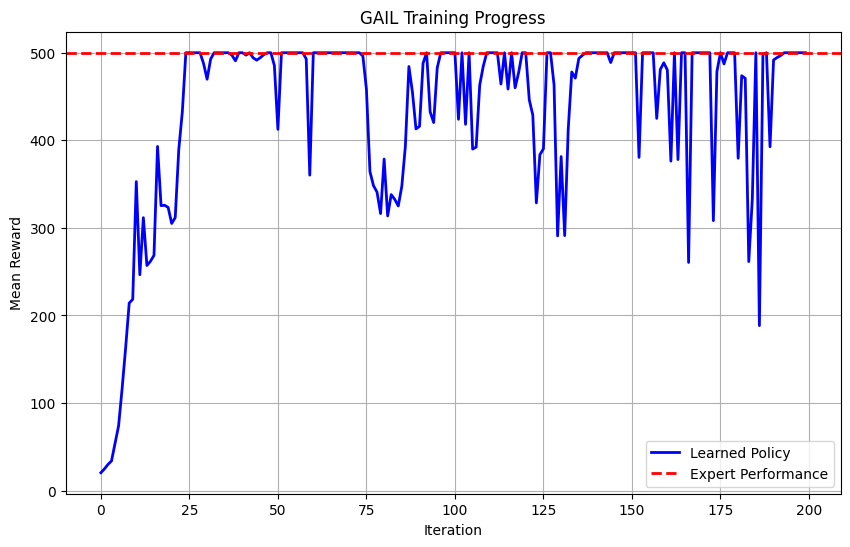

Expert reward: 500.000
Final learned reward: 500.000
Performance ratio: 100.0%


In [17]:
import matplotlib.pyplot as plt
with open(os.path.join("/kaggle/working/gail_model/ckpts/CartPole-v1/results.pkl"), "rb") as f:
       results = pickle.load(f)
exp_rwd_mean, rwd_iter_means = results

    # Simple plot
plt.figure(figsize=(10, 6))
plt.plot(rwd_iter_means, 'b-', linewidth=2, label='Learned Policy')
plt.axhline(y=exp_rwd_mean, color='r', linestyle='--', linewidth=2, label='Expert Performance')
plt.title('GAIL Training Progress')
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
plt.legend()
plt.grid(True)
plt.savefig("gail.pdf")
plt.show()

print(f"Expert reward: {exp_rwd_mean:.3f}")
print(f"Final learned reward: {rwd_iter_means[-1]:.3f}")
print(f"Performance ratio: {(rwd_iter_means[-1]/exp_rwd_mean)*100:.1f}%")

provide a plot like below:

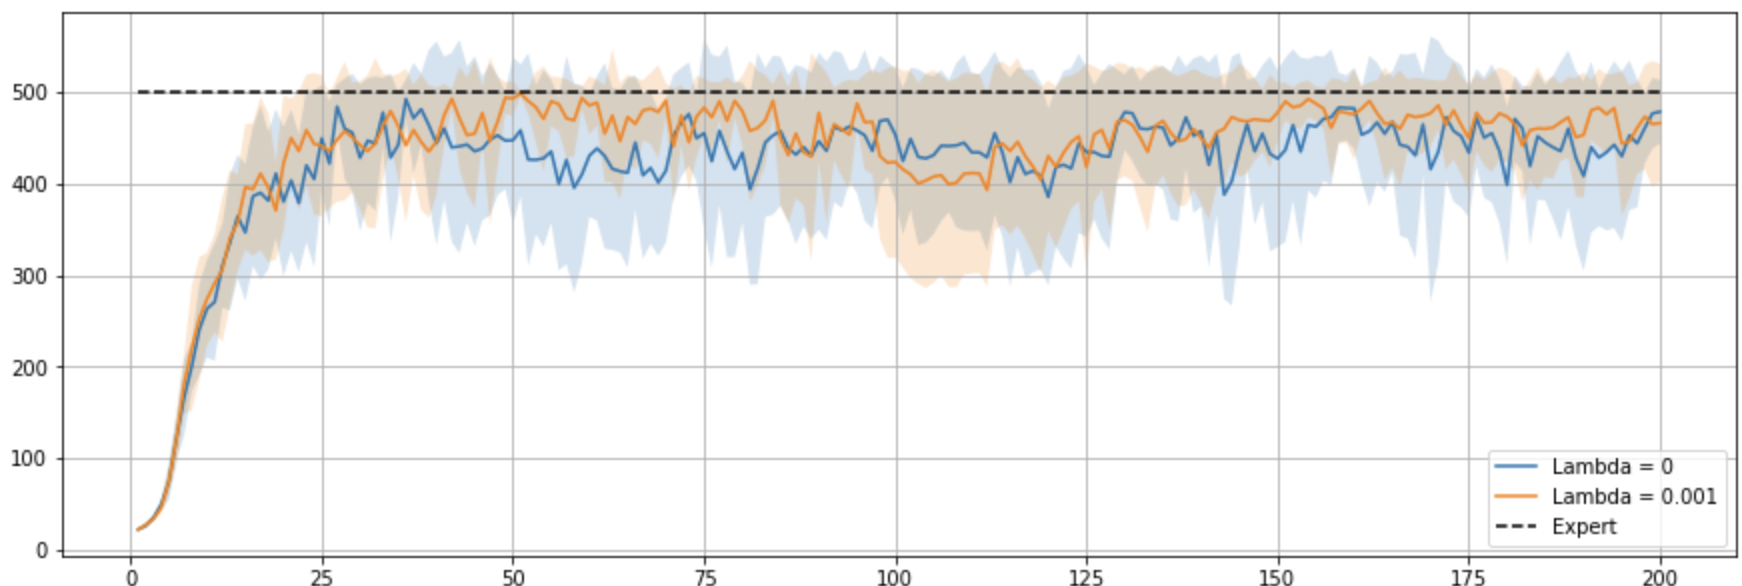